In [1]:
import io
import os
import re
import sys
import csv
import gzip
import time
import secrets
import multiprocessing
import subprocess
import resource
import numpy as np
# import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import itertools
import collections
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus
from lcwgsus.variables import *

from scipy.stats import poisson
from scipy.stats import chi2
from scipy.stats import friedmanchisquare
from scipy.stats import studentized_range
pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/

# from matplotlib import colormaps
# list(colormaps)

/gpfs3/well/band/users/rbx225/GAMCC


In [88]:
loci = ['A', 'B', 'C', 'DQB1', 'DRB1']
locis = [i+'1' for i in loci] + [i+'2' for i in loci]

hla = pd.read_csv('/well/band/users/rbx225/GAMCC/data/hla_direct_sequencing/HLA_direct_sequencing_all.csv')
hla = hla[['SampleID', 'Locus', 'Included Alleles', 'G code']]
hla = hla[hla['Locus'].isin(loci)].reset_index(drop = True)
hla['One field1'] = ''
hla['Two field1'] = ''

hla = hla.apply(resolve_ambiguous_hla_type, axis = 1)
hla = hla.drop(columns = ['Included Alleles', 'G code'])

for s in hla['SampleID'].unique():
    tmps = hla[hla['SampleID'] == s]
    for l in loci:
        tmpl = tmps[tmps['Locus'] == l]
        repeat = 2 - tmpl.shape[0]
        if repeat == 2:
            hla.loc[len(hla)] = [s, l, '-9', '-9']
            hla.loc[len(hla)] = [s, l, '-9', '-9']
        if repeat == 1:
            hla.loc[len(hla)] = [s, l, tmpl.iloc[0,2], tmpl.iloc[0, 3]]
hla = hla.sort_values(by = ['SampleID', 'Locus']).reset_index(drop = True)
hla = pd.concat([hla.iloc[::2].reset_index(drop=True), hla.iloc[1::2, 2:].reset_index(drop=True)], axis=1)
hla.columns = ['SampleID', 'Locus', 'One field1', 'Two field1', 'One field2', 'Two field2']
hla

,SampleID,Locus,One field1,Two field1,One field2,Two field2
0,GAM013489,A,02,02:01,02,02:01
1,GAM013489,B,44,44:03,82,82:01
2,GAM013489,C,03,03:02,03,03:03
3,GAM013489,DQB1,02,02:156/02:02,05,05:241/05:02
4,GAM013489,DRB1,09,09:31/09:01,16,16:02
...,...,...,...,...,...,...
1245,GAM982547,A,01,01:02,02,02:01
1246,GAM982547,B,45,45:01,57,57:03
1247,GAM982547,C,16,16:01,18,18:02
1248,GAM982547,DQB1,02,02:110/02:97/02:165/02:203/02:156/02:187/02:13...,03,03:19/03:485


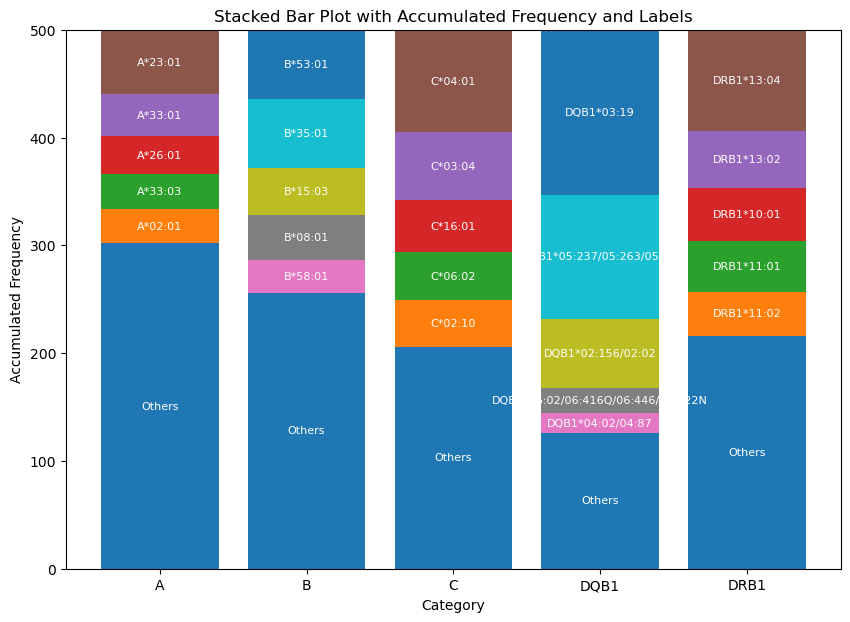

In [89]:
result = hla.melt(id_vars=['Locus'], value_vars=['Two field1', 'Two field2'], var_name='variable', value_name='Two field').drop(columns=['variable'])
result['Allele'] = result['Locus'] + '*' + result['Two field']
result = result.drop(columns = 'Two field')
hla_counts = result.groupby(['Locus', 'Allele']).size().unstack(fill_value=0)

# Function to keep top 5 hla_types and group the rest as 'Others'
def group_top_n(series, n=5):
    top_n = series.nlargest(n)
    rest = series[~series.index.isin(top_n.index)].sum()
    top_n['Others'] = rest
    return top_n

# Apply the function to each category
top_hla_counts = hla_counts.apply(group_top_n, axis=1)
lst = []
for i in loci:
    cols = top_hla_counts.columns[top_hla_counts.columns.str.startswith(i + '*')]
    tmp = top_hla_counts[cols]
    sorted_columns = tmp.loc[i].sort_values(ascending = True).index
    sorted_df = tmp[sorted_columns]

    lst.append(sorted_df)
res = pd.concat(lst, axis = 1)
res['Others'] = top_hla_counts['Others']
cols = ['Others'] + [col for col in res.columns if col != 'Others']
res = res[cols]

cumulative_sums = res.cumsum(axis=1)

fig, ax = plt.subplots(figsize=(10, 7))

for idx, col in enumerate(res.columns):
    ax.bar(res.index, res[col], bottom=res.iloc[:, :idx].sum(axis=1))
    
    for category in res.index:
        height = res.loc[category, col]
        if height > 0:
            bottom = cumulative_sums.loc[category, col] - height
            ax.text(x=category, y=bottom + height / 2, s=col, ha='center', va='center', fontsize=8, color='white')

# Adding labels and title
ax.set_xlabel('Category')
ax.set_ylabel('Accumulated Frequency')
ax.set_title('Stacked Bar Plot with Accumulated Frequency and Labels')

plt.show()

In [97]:
for i in loci:
    tmp = result[result['Locus'] == i]
    print(len(tmp['Allele'].unique()))
    print(i + ':', lcwgsus.calculate_shannon_entropy(tmp['Allele'].values))

25
A: 2.936753514637046
42
B: 3.10306944610165
25
C: 2.694755522216492
23
DQB1: 2.2287457592314484
31
DRB1: 2.7412108768907775


# Currently working on: HLA comparison

In [3]:
loci = ['A', 'B', 'C', 'DQB1', 'DRB1']
locis = [i+'1' for i in loci] + [i+'2' for i in loci]

def remove_superscripts(s):
    pattern = r'[:X\d]'
    matches = re.findall(pattern, s)
    result = ''.join(matches)
    return result

def resolve_ambiguous_hla_type(r):
    if pd.isna(r['Included Alleles']):
        r['Included Alleles'] = remove_superscripts(r['G code'])
    alleles = r['Included Alleles'].split('/')
    one_field = list(set([":".join(i.split(':', 1)[:1]) for i in alleles]))
    two_field = list(set([":".join(i.split(':', 2)[:2]) for i in alleles]))
    r['One field1'] =  '/'.join(one_field)
    r['Two field1'] = '/'.join(two_field)
    return r

def check_letter(s):
    for c in s:
        if c.isalpha():
            return True

def check_column(s):
    if ':' in s:
        return True

def clean_hla(r, locis = locis):
    for i in locis:
        allele = r[i]
        if check_letter(allele) or not check_column(allele):
            r[i] = '-9'
        else:
            r[i] = ":".join(allele.split(':', 2)[:2])
    return r

def compare_hla_types(r):
    typed = set(r[['A1', 'A2']])
    imputed = set(r[['bestallele1', 'bestallele2']])
    if typed == imputed:
        r['match'] = 2
    else:
        r['match'] = len(typed.intersection(imputed))
    return r

def check_one_field_match(typed, imputed, ix):
    colnames = ['One field1', 'One field2']
    typedalleles = set(typed.loc[ix, colnames])
    imputedalleles = set(imputed.loc[ix, colnames])
    if typedalleles == imputedalleles:
        typed.loc[ix, 'One field match'] = 2
    else:
        typed.loc[ix, 'One field match'] = len(typedalleles.intersection(imputedalleles))
    return typed

def check_two_field_match(typed, imputed, ix):
    colnames = ['Two field1', 'Two field2']
    typedallele1 = typed.loc[ix, 'Two field1'].split('/')
    typedallele2 = typed.loc[ix, 'Two field2'].split('/')
    imputedallele1 = imputed.loc[ix, 'Two field1']
    imputedallele2 = imputed.loc[ix, 'Two field2']
    
    typed.loc[ix, 'Two field match'] = max(np.sum((imputedallele1 in typedallele1) + (imputedallele2 in typedallele2)), np.sum((imputedallele2 in typedallele1) + (imputedallele1 in typedallele2)))
    return typed

def compare_hla_types(typed, imputed):
    typed = typed.copy()
    typed['One field match'] = 0
    typed['Two field match'] = 0
    for ix in range(len(typed)):
        typed = check_one_field_match(typed, imputed, ix)
        typed = check_two_field_match(typed, imputed, ix)   
    return typed

In [4]:
hla = pd.read_csv('/well/band/users/rbx225/GAMCC/data/hla_direct_sequencing/HLA_direct_sequencing_all.csv')
hla = hla[['SampleID', 'Locus', 'Included Alleles', 'G code']]
hla = hla[hla['Locus'].isin(loci)].reset_index(drop = True)
hla['One field1'] = ''
hla['Two field1'] = ''

hla = hla.apply(resolve_ambiguous_hla_type, axis = 1)
hla = hla.drop(columns = ['Included Alleles', 'G code'])

sample_linker = pd.read_csv('data/metadata/sample_linker.csv')
sample_linker = sample_linker[~sample_linker['Sample_Name'].str.contains('mini')]
fv = list(sample_linker['Chip_Name'].values)
hla = hla[hla['SampleID'].isin(fv)].reset_index(drop = True)

for s in hla['SampleID'].unique():
    tmps = hla[hla['SampleID'] == s]
    for l in loci:
        tmpl = tmps[tmps['Locus'] == l]
        repeat = 2 - tmpl.shape[0]
        if repeat == 2:
            hla.loc[len(hla)] = [s, l, '-9', '-9']
            hla.loc[len(hla)] = [s, l, '-9', '-9']
        if repeat == 1:
            hla.loc[len(hla)] = [s, l, tmpl.iloc[0,2], tmpl.iloc[0, 3]]
hla = hla.sort_values(by = ['SampleID', 'Locus']).reset_index(drop = True)
hla = pd.concat([hla.iloc[::2].reset_index(drop=True), hla.iloc[1::2, 2:].reset_index(drop=True)], axis=1)
hla.columns = ['SampleID', 'Locus', 'One field1', 'Two field1', 'One field2', 'Two field2']
hla

,SampleID,Locus,One field1,Two field1,One field2,Two field2
0,GAM013489,A,02,02:01,02,02:01
1,GAM013489,B,44,44:03,82,82:01
2,GAM013489,C,03,03:02,03,03:03
3,GAM013489,DQB1,02,02:156/02:02,05,05:241/05:02
4,GAM013489,DRB1,09,09:31/09:01,16,16:02
...,...,...,...,...,...,...
1045,GAM975418,A,29,29:02,33,33:01
1046,GAM975418,B,07,07:02,07,07:02
1047,GAM975418,C,15,15:05,15,15:05
1048,GAM975418,DQB1,04,04:02/04:87,05,05:237/05:263/05:01


In [165]:
sample_linker = pd.read_csv('data/metadata/sample_linker.csv')
idt_to_exclude = list(sample_linker[sample_linker['Sample_Name'].str.contains('mini')]['Seq_Name'].values)
sample_linker = {k:v for k, v in zip(sample_linker['Seq_Name'], sample_linker['Chip_Name'])}

imputed_lst = []
for g in loci:
    imputed = pd.read_csv('/well/band/users/rbx225/GAMCC/results/hla/imputation/genes/' + g + '/quilt.hla.output.combined.topresult.txt', sep = '\t')
    imputed = imputed[['sample_name', 'bestallele1', 'bestallele2', 'post_prob']]
    imputed['Locus'] = g
    imputed.columns = ['SampleID', 'Two field1', 'Two field2', 'prob', 'Locus']
    imputed['One field1'] = imputed['Two field1'].str.split('*').str.get(1).str.split(':').str.get(0)
    imputed['One field2'] = imputed['Two field2'].str.split('*').str.get(1).str.split(':').str.get(0)
    imputed['Two field1'] = imputed['Two field1'].str.split('*').str.get(1)
    imputed['Two field2'] = imputed['Two field2'].str.split('*').str.get(1)
    imputed = imputed[~imputed['SampleID'].isin(idt_to_exclude)]
    imputed['SampleID'] = imputed['SampleID'].apply(lambda x: sample_linker[x])
    imputed_lst.append(imputed)
imputed = pd.concat(imputed_lst).sort_values(by = ['SampleID', 'Locus']).reset_index(drop = True)
imputed = imputed[['SampleID', 'Locus', 'One field1', 'Two field1', 'One field2', 'Two field2', 'prob']]
imputed

,SampleID,Locus,One field1,Two field1,One field2,Two field2,prob
0,GAM013489,A,02,02:01,02,02:01,0.978304
1,GAM013489,B,44,44:03,82,82:01,0.999988
2,GAM013489,C,03,03:03,03,03:02,0.999898
3,GAM013489,DQB1,02,02:02,05,05:02,0.999999
4,GAM013489,DRB1,07,07:01,16,16:02,0.370618
...,...,...,...,...,...,...,...
1045,GAM975418,A,29,29:02,68,68:02,0.398663
1046,GAM975418,B,07,07:02,07,07:02,0.999996
1047,GAM975418,C,15,15:05,15,15:05,1.000000
1048,GAM975418,DQB1,05,05:01,04,04:02,1.000000


In [178]:
def calculate_hla_concordance(df):
    ccd_one = df['One field match'].sum()/(df.shape[0]*2)
    ccd_two = df['Two field match'].sum()/(df.shape[0]*2)
    return [ccd_one, ccd_two]

def generate_hla_imputation_report(df, source, loci = loci):
    report = pd.DataFrame(columns = ['Locus', 'Concordance', 'Resolution', 'Source'])
    for l in loci:
        tmp = df[df['Locus'] == l]
        ccd = calculate_hla_concordance(tmp)
        report.loc[len(report)] = [l, ccd[0], 'One field', source]
        report.loc[len(report)] = [l, ccd[1], 'Two field', source]
    return report

In [203]:
true_imp = compare_hla_types(hla, imputed)
lc_hla_report = generate_hla_imputation_report(true_imp, 'low-coverage')

In [153]:
vcf = lcwgsus.read_vcf('/well/band/users/rbx225/GAMCC/results/hla/server/chr6.dose.vcf.gz')
vcf = vcf[vcf['ID'].str.contains('HLA')]
vcf = vcf[VCF_COLS + list(vcf.columns[vcf.columns.isin(fv)])]
samples = list(vcf.columns[9:])
for i in samples:
    vcf[i] = vcf[i].apply(lcwgsus.encode_hla)
vcf = vcf.drop(columns = COMMON_COLS + ['QUAL', 'FILTER', 'INFO', 'FORMAT'])
vcf['Locus'] = vcf['ID'].str.split('*').str.get(0).str.split('_').str.get(1)
vcf['ID'] = vcf['ID'].str.split('*').str.get(1)
vcf = vcf[vcf['Locus'].isin(loci)]
vcf = vcf[['Locus', 'ID'] + samples].reset_index(drop = True)

combinations = list(itertools.product(samples, loci))
df = pd.DataFrame(combinations, columns=['SampleID', 'Locus'])
df['One field1'] = '-9'
df['Two field1'] = '-9'
df['One field2'] = '-9'
df['Two field2'] = '-9'

df = df.set_index(['SampleID', 'Locus'])

for s in samples:
    tmp = vcf[vcf[s] != 0][['Locus', 'ID', s]]
    
    onefield = tmp[tmp['ID'].str.split(':').str.len() == 1].reset_index(drop = True)
    twofield = tmp[tmp['ID'].str.split(':').str.len() == 2].reset_index(drop = True)
    
    for i in range(len(onefield.index)):
        l = onefield.loc[i, 'Locus']
        ID = onefield.loc[i, 'ID']
        dosage = onefield.loc[i, s]
        if dosage == 2:
            df.loc[(s, l), 'One field1'] = ID
            df.loc[(s, l), 'One field2'] = ID
        else:
            if df.loc[(s, l), 'One field1'] == '-9':
                df.loc[(s, l), 'One field1'] = ID
            else:
                df.loc[(s, l), 'One field2'] = ID
        
    for i in range(len(twofield.index)):
        l = twofield.loc[i, 'Locus']
        ID = twofield.loc[i, 'ID']
        dosage = twofield.loc[i, s]
        if dosage == 2:
            df.loc[(s, l), 'Two field1'] = ID
            df.loc[(s, l), 'Two field2'] = ID
        else:
            if df.loc[(s, l), 'Two field1'] == '-9':
                df.loc[(s, l), 'Two field1'] = ID
            else:
                df.loc[(s, l), 'Two field2'] = ID

df = df.reset_index().sort_values(by = ['SampleID', 'Locus'])
df

/tmp/slurm-57181430/ipykernel_85367/3458355341.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vcf['Locus'] = vcf['ID'].str.split('*').str.get(0).str.split('_').str.get(1)


,SampleID,Locus,One field1,Two field1,One field2,Two field2
0,GAM013489,A,02,02:01,02,02:01
1,GAM013489,B,44,44:03,82,82:01
2,GAM013489,C,03,03:02,03,03:03
3,GAM013489,DQB1,02,02:01,05,05:02
4,GAM013489,DRB1,09,09:01,16,16:02
...,...,...,...,...,...,...
925,GAM975418,A,29,29:02,33,33:01
926,GAM975418,B,07,07:02,07,07:02
927,GAM975418,C,15,15:05,15,15:05
928,GAM975418,DQB1,04,04:02,05,05:01


In [206]:
chip_hla = hla[hla['SampleID'].isin(samples)].sort_values(by = ['SampleID', 'Locus']).reset_index(drop = True)
true_chip = compare_hla_types(chip_hla, df)
chip_hla_report = generate_hla_imputation_report(true_chip, 'chip')

In [207]:
report = pd.concat([lc_hla_report, chip_hla_report])
report

,Locus,Concordance,Resolution,Source
0,A,0.852381,One field,low-coverage
1,A,0.785714,Two field,low-coverage
2,B,0.964286,One field,low-coverage
3,B,0.930952,Two field,low-coverage
4,C,0.988095,One field,low-coverage
5,C,0.976190,Two field,low-coverage
6,DQB1,0.997619,One field,low-coverage
7,DQB1,0.971429,Two field,low-coverage
8,DRB1,0.647619,One field,low-coverage
9,DRB1,0.530952,Two field,low-coverage


<Axes: xlabel='Concordance', ylabel='Locus'>

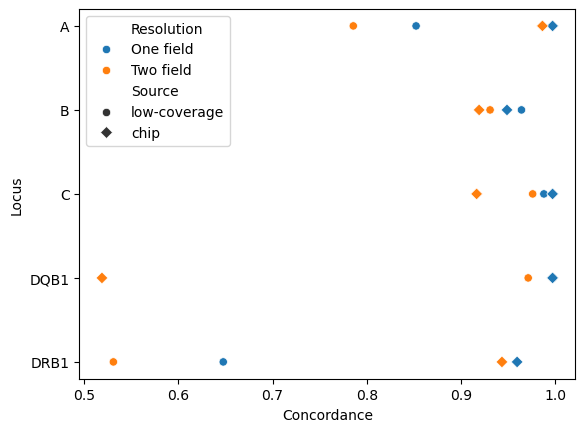

In [209]:
sns.scatterplot(data=report, x='Concordance', y='Locus', hue='Resolution', style='Source', markers={'low-coverage': 'o', 'chip': 'D'})

In [191]:
df[df['Locus'].str.contains('DQB')].reset_index(drop = True)

,SampleID,Locus,One field1,Two field1,One field2,Two field2
0,GAM013489,DQB1,02,02:01,05,05:02
1,GAM013627,DQB1,05,05:01,05,05:01
2,GAM013795,DQB1,03,03:01,03,03:02
3,GAM015283,DQB1,03,03:01,05,05:01
4,GAM018372,DQB1,03,03:01,05,05:01
...,...,...,...,...,...,...
181,GAM942670,DQB1,04,04:02,05,05:01
182,GAM946580,DQB1,05,05:01,05,05:01
183,GAM951206,DQB1,03,03:01,05,05:01
184,GAM967203,DQB1,02,02:01,02,02:01


In [194]:
chip_hla[chip_hla['Locus'].str.contains('DQB')].reset_index(drop = True)

,SampleID,Locus,One field1,Two field1,One field2,Two field2
0,GAM013489,DQB1,02,02:02/02:156,05,05:02/05:241
1,GAM013627,DQB1,05,05:263/05:237/05:01,05,05:263/05:237/05:01
2,GAM013795,DQB1,03,03:19,03,03:289/03:02/03:484/03:493/03:416
3,GAM015283,DQB1,03,03:19,05,05:263/05:237/05:01
4,GAM018372,DQB1,03,03:19,05,05:263/05:237/05:01
...,...,...,...,...,...,...
181,GAM942670,DQB1,04,04:02/04:87,05,05:263/05:237/05:01
182,GAM946580,DQB1,05,05:263/05:237/05:01,05,05:263/05:237/05:01
183,GAM951206,DQB1,03,03:19,05,05:263/05:237/05:01
184,GAM967203,DQB1,02,02:02/02:156,02,02:02/02:156


In [196]:
x = compare_hla_types(chip_hla, df)[compare_hla_types(chip_hla, df)['Locus'] == 'DQB1']
x

,SampleID,Locus,One field1,Two field1,One field2,Two field2,One field match,Two field match
3,GAM013489,DQB1,02,02:02/02:156,05,05:02/05:241,2,0
8,GAM013627,DQB1,05,05:263/05:237/05:01,05,05:263/05:237/05:01,2,0
13,GAM013795,DQB1,03,03:19,03,03:289/03:02/03:484/03:493/03:416,2,0
18,GAM015283,DQB1,03,03:19,05,05:263/05:237/05:01,2,0
23,GAM018372,DQB1,03,03:19,05,05:263/05:237/05:01,2,0
...,...,...,...,...,...,...,...,...
908,GAM942670,DQB1,04,04:02/04:87,05,05:263/05:237/05:01,2,0
913,GAM946580,DQB1,05,05:263/05:237/05:01,05,05:263/05:237/05:01,2,0
918,GAM951206,DQB1,03,03:19,05,05:263/05:237/05:01,2,0
923,GAM967203,DQB1,02,02:02/02:156,02,02:02/02:156,2,0


In [198]:
x['One field match'].sum()/372

0.9973118279569892

# Work in different catagories

In [22]:
# See this url for a documentation on more information on the array https://www.thermofisher.com/document-connect/document-connect.html?url=https://assets.thermofisher.com/TFS-Assets%2FLSG%2Fbrochures%2FGGNO07706-2_DS_Axiom_PMRA.pdf

db = sqlite3.connect("data/chip/Axiom_PMRA.na36.r1.a1.annot.db")
X = pd.read_sql_query("SELECT * FROM Annotations", db)
X['Associated_Gene'] = X['Associated_Gene'].str.split(' // ').str.get(-1)
X['Heterozygous_Allele_Frequencies'] = X['Heterozygous_Allele_Frequencies'].str.split(' /// ').str.get(-1).str.split(' // ').str.get(0)
X['Minor_Allele_Frequency'] = X['Minor_Allele_Frequency'].str.split(' /// ').str.get(-1).str.split(' // ').str.get(0)
X = X.drop(columns = ['ProbeSet_ID', 'Affy_SNP_ID', 'Strand', 'Stop',
                      'dbSNP_Loctype', 'In_Hapmap', 'Strand_Vs_dbSNP', 'Probe_Count',
                     'ChrX_PAR', 'Cytoband', 'Flank', 'Allele_A', 'Allele_B', 'Genetic_Map',
                     'Microsatellite', 'Allele_Frequency_Count', 'ClinVar_OMIM_Phenotype',
                     'ClinVar_OMIM_Description', 'ClinVar_MIM', 'EBI_PUBMEDID',
                     'EBI_MAPPED_GENE', 'EBI_SNPS', 'EBI_SNP_ID_CURRENT', 'EBI_MAPPED_TRAIT',
                     'EBI_MAPPED_TRAIT_URI', 'Allele_Frequencies', 'Minor_Allele', 'Ordered_Alleles',
                     'Annotation_Notes', 'extended_rsid', 'ClinVar_VariantID', 'Biomedical', 'ClinVar_RSID'])
X = X.rename(columns = {'Chr_id': 'chr', 'Start': 'pos', 'dbSNP_RS_ID': 'ID', 'Ref_Allele': 'ref', 'Alt_Allele': 'alt'})
X = X[X['chr'].astype(str).isin(CHROMOSOMES_ALL)]
X = X.sort_values(by = ['chr', 'pos'], ascending = True)
clin_cols = ['OMIM', 'ClinVar_ClinicalSignificance', 'ClinVar_GeneSymbol', 'ClinVar_Traits', 'ClinVar_OMIM_Gene']
for i in clin_cols:
    X[i] = X[i].astype(str)
X = X[~X[clin_cols].eq("None").all(axis=1)]
X

,chr,pos,ID,ref,alt,Associated_Gene,Heterozygous_Allele_Frequencies,Minor_Allele_Frequency,OMIM,Allele_Count,ClinVar_ClinicalSignificance,ClinVar_GeneSymbol,ClinVar_Traits,ClinVar_OMIM_Gene,EBI_DISEASE_TRAIT
162238,1,1005429.0,rs58913475,-,A,hes family bHLH transcription factor 4,0.4722,0.2731,147571 // Immunodeficiency 38 // 616126 // int...,2.0,None,None,None,None,None
682670,1,1005721.0,rs114443588,G,T,hes family bHLH transcription factor 4,0.1852,0.1111,147571 // Immunodeficiency 38 // 616126 // int...,2.0,None,None,None,None,None
595637,1,1011483.0,rs183136696,A,C,hes family bHLH transcription factor 4,0.0556,0.0278,147571 // Immunodeficiency 38 // 616126 // int...,2.0,None,None,None,None,None
682671,1,1012429.0,rs115074115,G,C,hes family bHLH transcription factor 4,0.0000,0.0000,147571 // Immunodeficiency 38 // 616126 // int...,2.0,None,None,None,None,None
506500,1,1014143.0,rs786201005,C,T,ISG15 ubiquitin-like modifier,None,None,147571 // Immunodeficiency 38 // 616126 // non...,2.0,PATHOGENIC,ISG15,IMMUNODEFICIENCY 38 WITH BASAL GANGLIA CALCIFI...,147571.0003,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901812,22,50744726.0,rs762191835,G,-,acrosin,None,None,102480 // ?Male infertility due to acrosin def...,2.0,None,None,None,None,None
703609,22,50747104.0,rs115392965,C,T,ribosomal protein L23a pseudogene 82,0.1111,0.0556,102480 // ?Male infertility due to acrosin def...,2.0,None,None,None,None,None
291819,22,50749396.0,rs141612488,C,T,ribosomal protein L23a pseudogene 82,0.2037,0.1204,102480 // ?Male infertility due to acrosin def...,2.0,None,None,None,None,None
785709,22,50749854.0,rs28420908,G,A,ribosomal protein L23a pseudogene 82,0.1944,0.0972,102480 // ?Male infertility due to acrosin def...,2.0,None,None,None,None,None


In [23]:
keywords = ['anemia', 'blood', 'Eryth']
keywords = '|'.join(keywords)

Y = X[X['OMIM'].str.contains(keywords, case=False, na=False)]

In [24]:
runs = ['lc_oneKG--chip--typed', 'lc_oneKG--hc--snps_gw', 'lc_oneKG_topmed--hc--snps_gw']
impaccs = []

for r in runs:
    h = [pd.read_csv('results/imputation_comparison/vanilla/' + r + '/impacc/all_samples/by_variant/chr' + str(i) + '.h.tsv', sep = '\t') for i in CHROMOSOMES_ALL]
    h = pd.concat(h)
    h = h[h['r2'] != -9]
    gwas = pd.merge(h, Y, on = ['chr', 'pos'])
    h_impacc = lcwgsus.generate_h_impacc(gwas)
    impaccs.append(h_impacc)

KeyboardInterrupt: 

In [ ]:
# impaccs[0].loc[[0,2], 'r2'] = 0
# impaccs[1].loc[0, 'r2'] = 0
# impaccs[2].loc[0, 'r2'] = 0

dfs = impaccs
labels = ['lc-chip', 'lc-1KG', 'lc-1KG-TOPMed']
title = 'Blood group variants r2'

# lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

In [36]:
bad = pd.read_csv('results/imputation_comparison/vanilla/lc_oneKG--chip--typed/impacc/all_samples/by_variant/all_r2less0.5.tsv', sep = '\t')
merged = pd.merge(X, bad, on = ['chr', 'pos']).drop_duplicates()
merged

,chr,pos,ID,ref_x,alt_x,Associated_Gene,Heterozygous_Allele_Frequencies,Minor_Allele_Frequency,OMIM,Allele_Count,ClinVar_ClinicalSignificance,ClinVar_GeneSymbol,ClinVar_Traits,ClinVar_OMIM_Gene,EBI_DISEASE_TRAIT,ref_y,alt_y,MAF,r2
0,1,1045444.0,None,G,C,agrin,0.2037,0.1111,"103320 // Myasthenic syndrome, congenital, 8, ...",2.0,LIKELY PATHOGENIC,AGRN,NOT PROVIDED,None,None,G,C,0.056306,0.363030
2,1,2254781.0,rs16824948,C,T,SKI proto-oncogene,0.0000,0.0000,164780 // Shprintzen-Goldberg syndrome // 1822...,2.0,None,None,None,None,None,C,T,0.011081,0.497019
3,1,3226751.0,rs114172340,G,A,PR domain containing 16,0.1574,0.0787,605557 // Left ventricular noncompaction 8 // ...,2.0,None,None,None,None,None,G,A,0.033921,0.397656
4,1,3444841.0,rs144140363,G,A,PR domain containing 16,0.0000,0.0000,605557 // Left ventricular noncompaction 8 // ...,2.0,None,None,None,None,None,G,A,0.000411,0.000292
5,1,3446243.0,rs80336315,A,G,PR domain containing 16,0.0000,0.0000,605557 // Left ventricular noncompaction 8 // ...,2.0,None,None,None,None,None,A,G,0.031425,0.288725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,22,40463302.0,rs73422615,G,A,megakaryoblastic leukemia (translocation) 1,0.1759,0.0972,"606078 // Megakaryoblastic leukemia, acute // ...",2.0,None,None,None,None,None,G,A,0.053384,0.460479
1168,22,45550014.0,rs114090291,G,A,fibulin 1,0.0463,0.0231,"135820 // Synpolydactyly, 3/3'4, associated wi...",2.0,None,None,None,None,None,G,A,0.012459,0.280887
1169,22,45590634.0,rs77622670,G,T,fibulin 1,0.0093,0.0046,"135820 // Synpolydactyly, 3/3'4, associated wi...",2.0,None,None,None,None,None,G,T,0.005792,0.486627
1170,22,45618766.0,rs116431142,A,G,long intergenic non-protein coding RNA 1589,0.0556,0.0278,611150 // Spinocerebellar ataxia 10 // 603516 ...,2.0,None,None,None,None,None,A,G,0.021781,0.263677


In [ ]:
clin_cols = ['OMIM', 'ClinVar_ClinicalSignificance', 'ClinVar_GeneSymbol', 'ClinVar_Traits', 'ClinVar_OMIM_Gene']

def absolute_numbers(val):
    absolute = int(val / 100. * counts.sum())
    return f'{absolute}'

for i in clin_cols:
    counts = merged[merged[i] != 'None'][i].value_counts()
    plt.figure(figsize=(8, 6))
    counts.plot.pie(autopct=absolute_numbers, startangle=90, counterclock=False)
    plt.ylabel('')  # Hide the y-label
    plt.title(i)
    plt.show()

In [61]:
hs = []
for i in CHROMOSOMES_ALL:
    t = pd.read_csv('results/imputation_comparison/vanilla/lc_oneKG--chip--typed/impacc/all_samples/by_variant/chr' + str(i) + '.h.tsv', sep = '\t')
    hs.append(t)
h = pd.concat(hs)
h

,chr,pos,ref,alt,MAF,NRC,NRC_BC,r2,r2_BC,ccd_homref,ccd_homref_BC,ccd_het,ccd_het_BC,ccd_homalt,ccd_homalt_BC
0,1,784860,T,C,0.959400,1.000000,183,0.997843,185,1.000000,2,1.000000,20,1.0,163
1,1,785910,G,C,0.025452,0.750000,8,0.842741,184,1.000000,176,0.750000,8,-9.0,0
2,1,788538,G,A,0.086260,0.973684,38,0.971634,186,1.000000,148,0.970588,34,1.0,4
3,1,818725,C,T,0.023735,0.875000,8,0.853221,185,1.000000,177,0.875000,8,-9.0,0
4,1,819249,A,G,0.025074,0.875000,8,0.857605,186,1.000000,178,0.875000,8,-9.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12132,22,50749854,G,A,0.093138,0.956522,23,0.983148,186,1.000000,163,0.952381,21,1.0,2
12133,22,50749890,T,G,0.025043,1.000000,5,0.999999,185,1.000000,180,1.000000,5,-9.0,0
12134,22,50770140,G,T,0.261949,0.958763,97,0.950049,186,0.967391,92,0.987805,82,1.0,12
12135,22,50777904,G,A,0.041119,0.944444,18,0.974504,185,0.994048,168,1.000000,17,-9.0,0


In [67]:
window = 1e5
means = []
for snp in range(len(merged)):
    means.append(plot_imputation_metric_in_region(h, merged.iloc[snp, 0], merged.iloc[snp, 1], window = window, show_fig = False))

In [69]:
means = np.array(means)
means.argmin()
lcwgsus.plot_imputation_metric_in_region(h, merged.iloc[58, 0], merged.iloc[58, 1], window = 1e6, show_fig = True)

means.sort()

58